In [1]:
import util.preprocessing as preprocessing
import util.detection_util as detection_util

import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import cv2
import os
import xlrd
import openpyxl
import matplotlib.pyplot as plt
import util.config as config

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 12,
    'style'  : 'normal'}
font0 = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 12,
    'style'  : 'italic'}

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['figure.dpi']= 300
plt.rcParams['patch.antialiased'] = True
plt.rcParams['lines.antialiased'] = True
plt.rcParams['text.antialiased'] = True
plt.rcParams['figure.figsize'] = [6, 3]

plt.rc('font', **font)
plt.rc('text', usetex=False)

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


In [2]:
df = pd.read_excel(r'D:\Users\avatar\PycharmProjects\pig-face-recognition\sample\train.xlsx')
print(df.head().to_string())
df.head(5)

             image_name  pig_name  age     bright  contrast           createdate flash  img_height  img_width setversion  sex  sharpness type  weight perspective  full_pig_face  over_exposed missing_element
0  DSC_V1_6460_2238.JPG      6460    0  64.920095       1.0  2021:02:02 07:01:27   [7]        2848       4288         V1  NaN  31.764733  jpg       0           f              1           NaN             NaN
1  DSC_V1_6460_2239.JPG      6460    0  68.491263       1.0  2021:02:02 07:01:34   [7]        2848       4288         V1  NaN  47.600315  jpg       0           f              1           NaN             NaN
2  DSC_V1_6460_2240.JPG      6460    0  61.175416       1.0  2021:02:02 07:01:35   [7]        2848       4288         V1  NaN  58.129255  jpg       0           t              1           NaN             NaN
3  DSC_V1_6460_2241.JPG      6460    0  71.499618       1.0  2021:02:02 07:02:10   [7]        2848       4288         V1  NaN  25.567715  jpg       0           t           

,image_name,pig_name,age,bright,contrast,createdate,flash,img_height,img_width,setversion,sex,sharpness,type,weight,perspective,full_pig_face,over_exposed,missing_element
0,DSC_V1_6460_2238.JPG,6460,0,64.920095,1.0,2021:02:02 07:01:27,[7],2848,4288,V1,NaN,31.764733,jpg,0,f,1,NaN,NaN
1,DSC_V1_6460_2239.JPG,6460,0,68.491263,1.0,2021:02:02 07:01:34,[7],2848,4288,V1,NaN,47.600315,jpg,0,f,1,NaN,NaN
2,DSC_V1_6460_2240.JPG,6460,0,61.175416,1.0,2021:02:02 07:01:35,[7],2848,4288,V1,NaN,58.129255,jpg,0,t,1,NaN,NaN
3,DSC_V1_6460_2241.JPG,6460,0,71.499618,1.0,2021:02:02 07:02:10,[7],2848,4288,V1,NaN,25.567715,jpg,0,t,1,NaN,NaN
4,DSC_V1_6460_2242.JPG,6460,0,45.096860,1.0,2021:02:02 07:02:11,[7],2848,4288,V1,NaN,9.974902,jpg,0,t,1,NaN,NaN


In [3]:
df = df.astype({'image_name': 'str', 'perspective': 'str', 'full_pig_face': 'int'})
df['perspective'] = pd.Categorical(df.perspective)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   image_name       518 non-null    object  
 1   pig_name         518 non-null    int64   
 2   age              518 non-null    int64   
 3   bright           518 non-null    float64 
 4   contrast         518 non-null    float64 
 5   createdate       518 non-null    object  
 6   flash            518 non-null    object  
 7   img_height       518 non-null    int64   
 8   img_width        518 non-null    int64   
 9   setversion       518 non-null    object  
 10  sex              0 non-null      float64 
 11  sharpness        518 non-null    float64 
 12  type             518 non-null    object  
 13  weight           518 non-null    int64   
 14  perspective      518 non-null    category
 15  full_pig_face    518 non-null    int32   
 16  over_exposed     26 non-null     float64 
 1

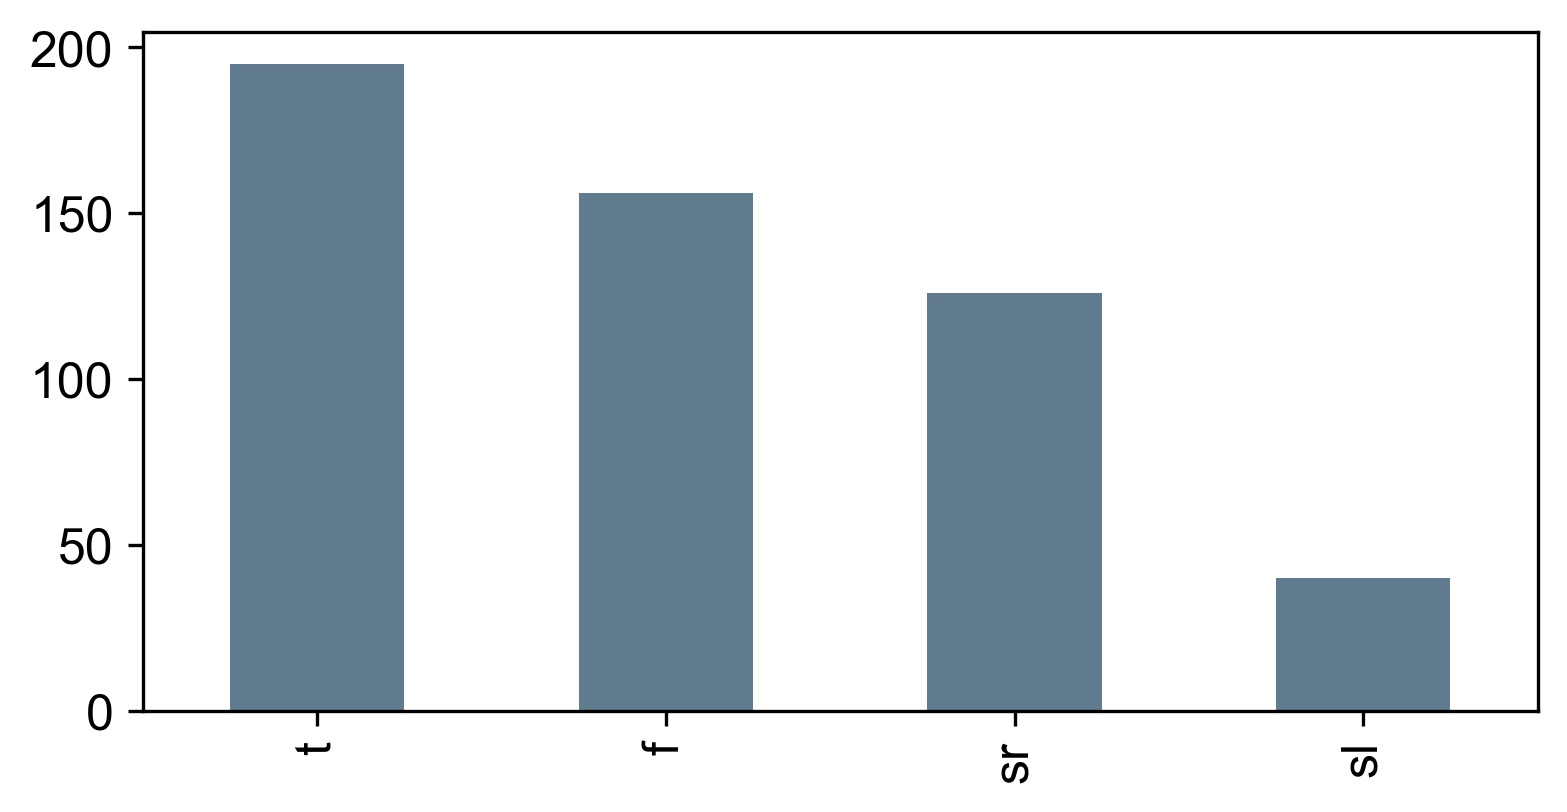

t     195
f     156
sr    126
sl     40
Name: perspective, dtype: int64


In [4]:
ax = df.perspective.value_counts().reindex(["t", "f", "sr", "sl"]).plot(kind="bar", color='#607c8e')
plt.show()
print (df.perspective.value_counts().reindex(["t", "f", "sr", "sl"]))

In [5]:
# Filter df, use only perspective front and top

df_f = df['perspective']=='f'
print(df_f.head().to_string())

0     True
1     True
2    False
3    False
4    False


In [6]:
df_q = df.query('(perspective == "t" or perspective == "f") & over_exposed != 1 & missing_element.isnull()')
df_q = df_q.query('bright >= 30')
df_q = df_q.query('sharpness >= 11')
df_q = df_q.sort_values('image_name')


print(df_q.head(15).to_string())
index = df_q.index
print (len(index))

              image_name  pig_name  age     bright  contrast           createdate flash  img_height  img_width setversion  sex  sharpness type  weight perspective  full_pig_face  over_exposed missing_element
0   DSC_V1_6460_2238.JPG      6460    0  64.920095       1.0  2021:02:02 07:01:27   [7]        2848       4288         V1  NaN  31.764733  jpg       0           f              1           NaN             NaN
1   DSC_V1_6460_2239.JPG      6460    0  68.491263       1.0  2021:02:02 07:01:34   [7]        2848       4288         V1  NaN  47.600315  jpg       0           f              1           NaN             NaN
2   DSC_V1_6460_2240.JPG      6460    0  61.175416       1.0  2021:02:02 07:01:35   [7]        2848       4288         V1  NaN  58.129255  jpg       0           t              1           NaN             NaN
3   DSC_V1_6460_2241.JPG      6460    0  71.499618       1.0  2021:02:02 07:02:10   [7]        2848       4288         V1  NaN  25.567715  jpg       0           t      

In [7]:
# Group by pig_name
df_group_by_pig_name = df_q.groupby('pig_name').count()
df_group_by_pig_name.head()


,image_name,age,bright,contrast,createdate,flash,img_height,img_width,setversion,sex,sharpness,type,weight,perspective,full_pig_face,over_exposed,missing_element
pig_name,,,,,,,,,,,,,,,,,
6357,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,0,0
6358,6,6,6,6,6,6,6,6,6,0,6,6,6,6,6,0,0
6367,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,0,0
6377,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3,0,0
6385,6,6,6,6,6,6,6,6,6,0,6,6,6,6,6,0,0


In [8]:
df_group_by_pig_name = df_group_by_pig_name.query('(image_name >= 5)')
print (df_group_by_pig_name.to_string())
index = df_group_by_pig_name.index
print ('----------------------------------------------------------------------')
print (len(index))



          image_name  age  bright  contrast  createdate  flash  img_height  img_width  setversion  sex  sharpness  type  weight  perspective  full_pig_face  over_exposed  missing_element
pig_name                                                                                                                                                                                  
6358               6    6       6         6           6      6           6          6           6    0          6     6       6            6              6             0                0
6385               6    6       6         6           6      6           6          6           6    0          6     6       6            6              6             0                0
6390               9    9       9         9           9      9           9          9           9    0          9     9       9            9              9             0                0
6408               5    5       5         5           5      5   

In [9]:
# Print the clean pig_names Index List 
print (df_group_by_pig_name.index)


Int64Index([6358, 6385, 6390, 6408, 6418, 6422, 6432, 6444, 6446, 6460, 6472,
            6476, 6489, 6495, 6497, 6503, 6507, 6512, 6516, 6518, 6520, 6522,
            6523, 6524, 6525, 6527, 6529, 6531, 6551, 6552, 6555, 6557, 6558,
            6560, 6566, 6574, 6575, 6578, 6589],
           dtype='int64', name='pig_name')
